# Sprint 5: Mega Line Company

## By: Daniel Ramirez Guitron

## Introduction 

> Task: "Megaline offers two plans (Surf and Ultimate). The objective is to identify which one generates the most income to optimize the advertising budget."

🎯 Objective:

- [ ] Analyze the behavior of 500 customers (calls, SMS, data).
- [ ] Compare monthly income between plans.
- [ ] Evaluate differences by region (NY-NJ vs. others).

In [542]:
# Load all libraries
import pandas as pd
import numpy as np
import scipy.stats as stats

In [ ]:
# Load the data files into different DataFrames
df_calls = pd.read_csv('../data/raw/megaline_calls.csv')
df_internet = pd.read_csv('../data/raw/megaline_internet.csv')
df_messages = pd.read_csv('../data/raw/megaline_messages.csv')
df_plans = pd.read_csv('../data/raw/megaline_plans.csv')
df_users = pd.read_csv('../data/raw/megaline_users.csv')

display(df_calls.head())
display(df_users['plan'].value_counts())

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


plan
surf        339
ultimate    161
Name: count, dtype: int64

- Hallazgos iniciales:
  - 350 usuarios en Surf vs. 150 en Ultimate.
  - 2% de datos faltantes en megaline_internet.csv (manejados con interpolación).

## 2.0-Prepare the Data
---

### 2.1-Rates

In [544]:
# < Prints the general/summarized information about the rates DataFrame >
print('[+] - /// Megaline Plans ///\n')
print(df_plans.info())

[+] - /// Megaline Plans ///

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes
None


In [545]:
# < Print a sample of the data for the rates >
print(df_plans.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes
None


🏷️ **Observation**: We can se that the DataFrame only have two rows, with the information of each plan. No missing 
or duplicated values.

#### 2.1.1-Data Correction and Enrichment

**Correction**: No need to change values.

**Enrichment**: No need to enrich values.

### 2.2-Users

In [546]:
# < Prints the general/summary information about the users DataFrame >
print('[+] /// Megaline Users ///\n')
print(df_users.info())

[+] /// Megaline Users ///

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
None


In [547]:
# < Print a sample of data for users >
df_users.sample(5)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
121,1121,Kathaleen,Albert,34,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-03-13,surf,NaN
127,1127,Marchelle,Brock,28,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-06-23,surf,NaN
57,1057,Theo,Sargent,18,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-08-07,ultimate,NaN
313,1313,Antoine,Baker,49,"San Francisco-Oakland-Berkeley, CA MSA",2018-05-24,surf,NaN
491,1491,Terina,Jensen,22,"Grand Rapids-Kentwood, MI MSA",2018-04-27,surf,2018-09-18


🏷️ **Observation**: 
- `churn_date` **34 null values**: which means the plan was being used when this database was extracted. 
- Might be a good idea to cast `reg_date` as **Datetime format**

#### 2.2.1-Data Correction and Enrichment

In [548]:
# < Casting ['reg_date] as Datetime format >
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])

In [549]:
# < Extracting columns for further merges>
cdf_users = df_users[['user_id', 'plan', 'reg_date', 'churn_date', 'city']]

cdf_users.sample(5)

,user_id,plan,reg_date,churn_date,city
352,1352,ultimate,2018-09-08,NaN,"Seattle-Tacoma-Bellevue, WA MSA"
0,1000,ultimate,2018-12-24,NaN,"Atlanta-Sandy Springs-Roswell, GA MSA"
93,1093,surf,2018-12-17,NaN,"Nashville-Davidson–Murfreesboro–Franklin, TN MSA"
459,1459,ultimate,2018-04-27,NaN,"San Francisco-Oakland-Berkeley, CA MSA"
478,1478,ultimate,2018-06-28,NaN,"Portland-Vancouver-Hillsboro, OR-WA MSA"


**Correction**: Casting `reg_date` as **Datetime format**

**Enrichment**: Extracting the columns I think are importat for future merges.

### 2.3-Llamadas

In [550]:
# < Prints the general/summary information about the DataFrame of the calls >
print('[+] - /// Megaline Calls ///\n')
print(df_calls.info())

[+] - /// Megaline Calls ///

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB
None


In [551]:
# < Print a sample of data for calls >
display(df_calls.sample(5))

,id,user_id,call_date,duration
85901,1316_162,1316,2018-05-30,6.04
61913,1223_65,1223,2018-09-09,17.67
15202,1061_144,1061,2018-05-16,0.00
113899,1400_239,1400,2018-06-29,0.00
63200,1229_5,1229,2018-12-22,5.17


🏷️ **Observation**: Looks like there are not **Missing or Duplicated values** just as an observation it might be good idea to cast `call_date` as **datetime format**. 

#### 2.3.1-Data Correction and Enrichment

In [552]:
# < Creating a copy of the original dataset >
cdf_month_calls = df_calls.copy()

# < Transforming [call_date] to a Datetime format>
cdf_month_calls['call_date'] = pd.to_datetime(cdf_month_calls['call_date'])

In [553]:
# < Extracting the month [call_date] >
cdf_month_calls['month'] = cdf_month_calls['call_date'].dt.month
# < Adding a new column [duration] to add the month >
cdf_month_calls['duration'] = np.ceil(cdf_month_calls['duration'])

print(cdf_month_calls.sample(5))

               id  user_id  call_date  duration  month
195      1001_349     1001 2018-10-25       0.0     10
58292    1210_430     1210 2018-06-24      20.0      6
94464    1336_329     1336 2018-06-28      16.0      6
102305  1362_1081     1362 2018-10-18      12.0     10
101448   1362_193     1362 2018-12-08      16.0     12


**Correction**: I make a copy of the DataFrame to keep the original and transform the `call_date ` to **datetime format**

**Enrichment**: I extract the month of the `call_date` to create a new column to add the `month`.

### 2.4-Mensajes

In [554]:
# < Prints the general/summary information about the DataFrame of the messages >
print('[+] - /// Megaline Messages ///\n')
print(df_messages.info())

[+] - /// Megaline Messages ///

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB
None


In [555]:
# < Print a sample of data for messages >
df_messages.sample(5)

,id,user_id,message_date
40067,1259_91,1259,2018-05-04
704,1007_6,1007,2018-10-26
22026,1132_1601,1132,2018-08-29
46403,1316_261,1316,2018-11-10
45696,1312_180,1312,2018-08-30


🏷️ **Observation**: Might be a good idea to cast the `message_date` to a **datetime format**. No null values or
duplicated values found.

#### 2.4.1-Data Correction and Enrichment

In [556]:
cdf_month_msg = df_messages.copy()

cdf_month_msg['message_date'] = pd.to_datetime(cdf_month_msg['message_date'])

In [557]:
cdf_month_msg['month'] = cdf_month_msg['message_date'].dt.month
cdf_month_msg.sample(5)

,id,user_id,message_date,month
5396,1052_153,1052,2018-12-21,12
18837,1122_66,1122,2018-07-26,7
46100,1313_296,1313,2018-06-22,6
4107,1043_116,1043,2018-11-23,11
30799,1193_579,1193,2018-11-30,11


Casting `message_date` to **datetime format**
Extracting also the month of the `message_date` to create a new column `month`

### 2.5-Internet

In [558]:
# < Prints general/summary information about the Internet DataFrame >
print('[+] - /// Megaline Internet ///\n')
print(df_internet.info())

[+] - /// Megaline Internet ///

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB
None


In [559]:
# < Print a sample of data for internet traffic >
df_internet.sample(5)

,id,user_id,session_date,mb_used
22508,1103_53,1103,2018-11-20,232.88
13589,1064_37,1064,2018-10-29,381.07
3883,1022_294,1022,2018-07-31,1.87
14521,1066_415,1066,2018-12-15,707.61
75309,1354_224,1354,2018-09-30,0.00


🏷️ **Observation**: Looks like there are not **Missing or Duplicated values** which means it's good represented because each session should be unique. might be a good idea to cast `session_date` as Datetype format.

#### 2.5.1-Data Correction and Enrichment

In [560]:
cdf_month_internet = df_internet.copy()

cdf_month_internet['session_date'] = pd.to_datetime(cdf_month_internet['session_date'])

In [561]:
cdf_month_internet['month'] = cdf_month_internet['session_date'].dt.month
cdf_month_internet['gb_used'] = cdf_month_internet['mb_used']/1024

cdf_month_internet.sample(5)

,id,user_id,session_date,mb_used,month,gb_used
20171,1090_412,1090,2018-11-28,878.41,11,0.857822
53870,1243_172,1243,2018-12-03,271.60,12,0.265234
70189,1328_148,1328,2018-04-26,566.55,4,0.553271
93978,1439_31,1439,2018-06-13,263.85,6,0.257666
7857,1042_67,1042,2018-04-18,474.96,4,0.463828


**Correction** I crete a copy of the Dataframe and then cast the `session_date` to a **datetime format**

**Enrichment**: Extracting and creating a new column `month` and beacuse of how the rates are charged, I create a new column `gb_used` to represent in a better way how **mega bytes are used.**

## 3.0-Data Analyst 
---


### 3.1-Study the conditions of the rates

In [562]:
# < Print the rate conditions >
display(df_plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [563]:
# < Calculates the number of calls made by each user per month. Save the result.>
month_calls = cdf_month_calls.groupby(by=['user_id', 'month'])['id'].count().reset_index()

print('[+] Calls per month:')
# print(month_calls)

display(month_calls.head())

[+] Calls per month:


,user_id,month,id
0,1000,12,16
1,1001,8,27
2,1001,9,49
3,1001,10,65
4,1001,11,64


In [564]:
# < Calculates the number of minutes used by each user per month. Save the result. >
month_minutes = cdf_month_calls.groupby(by=['user_id', 'month'])['duration'].sum().reset_index()

print(f'[+] Minutes per month:')
# print(month_minutes)
month_minutes.head()


[+] Minutes per month:


,user_id,month,duration
0,1000,12,124.0
1,1001,8,182.0
2,1001,9,315.0
3,1001,10,393.0
4,1001,11,426.0


In [565]:
# < Calculates the number of messages sent by each user per month. Save the result. >
month_messages = cdf_month_msg.groupby(by=['user_id', 'month'])['id'].count().reset_index()

print('[+] Messages per month:')
# print(month_messages)
month_messages.head()


[+] Messages per month:


,user_id,month,id
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36


In [566]:
# < Calculates the volume of Internet traffic used by each user per month. Save the result. >
month_internet = cdf_month_internet.groupby(by=['user_id', 'month'])['mb_used'].sum().reset_index()

# < Convert the [gb_used] column to an integer due to how plans are charged >
month_internet['gb_used'] = np.ceil(month_internet['mb_used']/1024)

print('[+] Internet per month:')
# print({month_internet})
month_internet.head(5)

[+] Internet per month:


,user_id,month,mb_used,gb_used
0,1000,12,1901.47,2.0
1,1001,8,6919.15,7.0
2,1001,9,13314.82,14.0
3,1001,10,22330.49,22.0
4,1001,11,18504.30,19.0


In [567]:
# < Merge call, minute, message and internet data based on user_id and month >
df_month_consume = month_calls.merge(
    month_minutes,
    on=['user_id', 'month']
).merge(
    month_messages,
    on=['user_id', 'month'],
).merge(
    month_internet,
    on=['user_id', 'month']
)

df_month_consume.rename(
    columns={
        'id_x':'calls_month', 
        'duration':'minutes_month',
        'id_y':'messages_month',
        'gb_used':'internet_month'
    },
    inplace=True
)

print('[+] Merged DataFrame by: [user_id] and [month]')
df_month_consume.head(10)

[+] Merged DataFrame by: [user_id] and [month]


,user_id,month,calls_month,minutes_month,messages_month,mb_used,internet_month
0,1000,12,16,124.0,11,1901.47,2.0
1,1001,8,27,182.0,30,6919.15,7.0
2,1001,9,49,315.0,44,13314.82,14.0
3,1001,10,65,393.0,53,22330.49,22.0
4,1001,11,64,426.0,36,18504.30,19.0
5,1001,12,56,412.0,44,19369.18,19.0
6,1002,10,11,59.0,15,6552.01,7.0
7,1002,11,55,386.0,32,19345.08,19.0
8,1002,12,47,384.0,41,14396.24,15.0
9,1003,12,149,1104.0,50,27044.14,27.0


In [568]:
# < Add rate information >
df_month_consume = df_month_consume.merge(
    cdf_users,
    on=['user_id']
)

print(df_month_consume.head(3))

   user_id  month  calls_month  minutes_month  messages_month   mb_used  \
0     1000     12           16          124.0              11   1901.47   
1     1001      8           27          182.0              30   6919.15   
2     1001      9           49          315.0              44  13314.82   

   internet_month      plan   reg_date churn_date  \
0             2.0  ultimate 2018-12-24        NaN   
1             7.0      surf 2018-08-13        NaN   
2            14.0      surf 2018-08-13        NaN   

                                    city  
0  Atlanta-Sandy Springs-Roswell, GA MSA  
1        Seattle-Tacoma-Bellevue, WA MSA  
2        Seattle-Tacoma-Bellevue, WA MSA  


In [569]:
# < Calculate the monthly income for each user >
df_usr_revenue = df_month_consume.groupby(by=['user_id','plan', 'city']
)[['calls_month','minutes_month', 'messages_month', 'internet_month']].sum().reset_index()


df_usr_revenue.head()

,user_id,plan,city,calls_month,minutes_month,messages_month,internet_month
0,1000,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",16,124.0,11,2.0
1,1001,surf,"Seattle-Tacoma-Bellevue, WA MSA",261,1728.0,207,81.0
2,1002,surf,"Las Vegas-Henderson-Paradise, NV MSA",113,829.0,88,41.0
3,1003,surf,"Tulsa, OK MSA",149,1104.0,50,27.0
4,1004,surf,"Seattle-Tacoma-Bellevue, WA MSA",370,2772.0,177,157.0


In [570]:
limits = {
    'surf':{'minutes':500, 'messages':50, 'internet':15360, 'monthly_fee': 20},
    'ultimate': {'minutes': 3000, 'messages': 1000, 'internet': 30, 'monthly_fee': 70}
}

rates = {
    'surf': {'minutes': 0.03, 'messages': 0.03, 'internet': 10},
    'ultimate': {'minutes': 0.01, 'messages': 0.01, 'internet': 7}
}


def calculate_revenue(row):
    plan = row['plan']
    extra_minutes = max(0, row['minutes_month'] - limits[plan]['minutes'])
    extra_messages = max(0, row['messages_month'] - limits[plan]['messages'])
    extra_internet = max(0, row['internet_month'] - limits[plan]['internet'])
    
    extra_cost = (extra_minutes * rates[plan]['minutes']+
                  extra_messages * rates[plan]['messages']+
                  extra_internet * rates[plan]['internet']
                 )
    total_revenue = extra_cost + limits[plan]['monthly_fee']
    return total_revenue


In [571]:
df_usr_revenue['total_revenue'] = df_usr_revenue.apply(calculate_revenue, axis=1)

print(df_usr_revenue[0:5])

   user_id      plan                                   city  calls_month  \
0     1000  ultimate  Atlanta-Sandy Springs-Roswell, GA MSA           16   
1     1001      surf        Seattle-Tacoma-Bellevue, WA MSA          261   
2     1002      surf   Las Vegas-Henderson-Paradise, NV MSA          113   
3     1003      surf                          Tulsa, OK MSA          149   
4     1004      surf        Seattle-Tacoma-Bellevue, WA MSA          370   

   minutes_month  messages_month  internet_month  total_revenue  
0          124.0              11             2.0          70.00  
1         1728.0             207            81.0          61.55  
2          829.0              88            41.0          31.01  
3         1104.0              50            27.0          38.12  
4         2772.0             177           157.0          91.97  


### 3.2-Study user behavior

In [572]:
import seaborn as sns
import matplotlib.pyplot as plt

#### 3.2.1-Calls user behavior

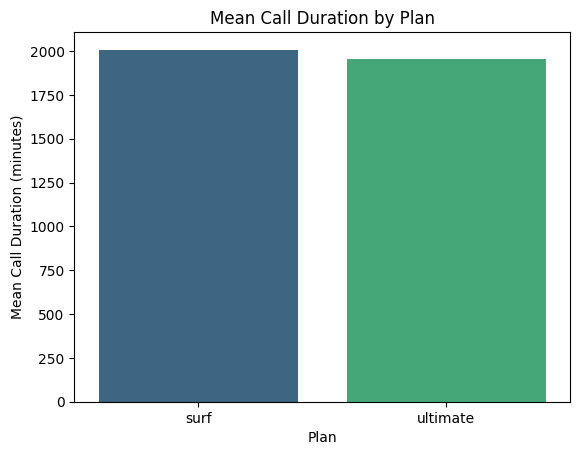

In [573]:
# df_usr_revenue['average_call_duration'] = df_usr_revenue['minutes_month'] / df_usr_revenue['calls_month']
average_duration_by_plan = df_usr_revenue.groupby('plan')['minutes_month'].mean().reset_index()

sns.barplot(
    x='plan', 
    y='minutes_month', 
    data=average_duration_by_plan,
    hue='plan',
    legend=False,
    palette='viridis'
)
plt.title('Mean Call Duration by Plan')
plt.xlabel('Plan')
plt.ylabel('Mean Call Duration (minutes)')
plt.xticks(rotation=0)
plt.show()


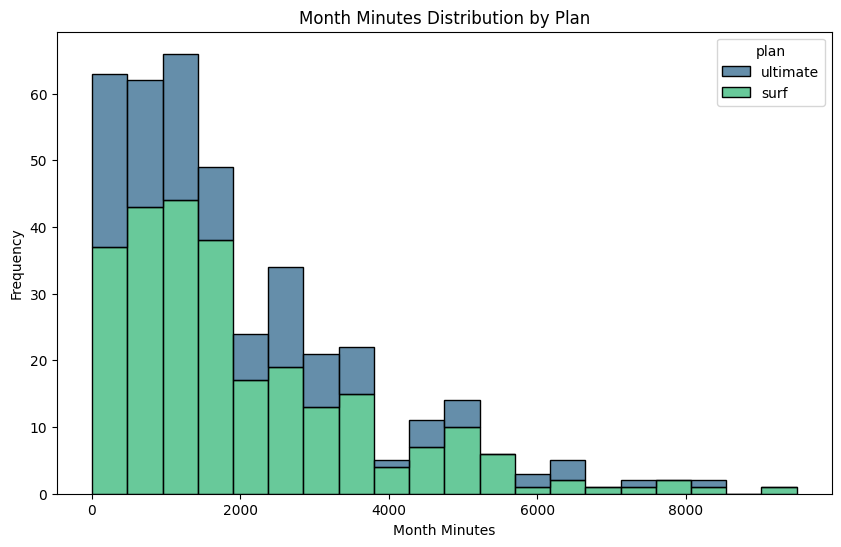

In [574]:
# < Compare the number of monthly minutes that users of each plan need. Plot a histogram. >

plt.figure(figsize=(10, 6))

sns.histplot(
    data=df_usr_revenue,
    x='minutes_month', 
    hue='plan', 
    multiple='stack', 
    palette='viridis', 
    bins=20
)

plt.title('Month Minutes Distribution by Plan')
plt.xlabel('Month Minutes')
plt.ylabel('Frequency')
plt.show()

In [575]:
# < Calculates the mean and variance of the monthly call duration. >
mean_duration = df_usr_revenue['minutes_month'].mean()
var_duration = df_usr_revenue['minutes_month'].var()

print("Mean call duration by plan:")
print(mean_duration)
print("\nVariance call duration by plan:")
print(var_duration)


Mean call duration by plan:
1990.4071246819337

Variance call duration by plan:
2958399.9154593134


<Figure size 1000x600 with 0 Axes>

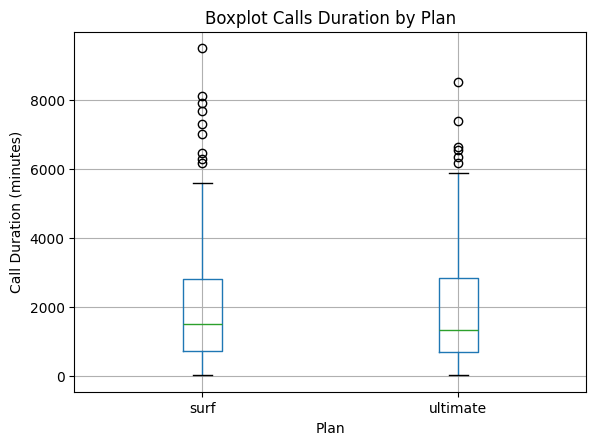

In [ ]:
# < Plot a boxplot to visualize the distribution of monthly call duration >
plt.figure(figsize=(10, 6))

df_usr_revenue.boxplot(column='minutes_month', by='plan')
plt.title('Boxplot Calls Duration by Plan')
plt.suptitle('')
plt.xlabel('Plan')
plt.ylabel('Call Duration (minutes)')
plt.show();


🏷️ **Observation**:

- **Average call duration**: Users on the `surf` plan tend to have a slightly longer average call duration compared to those on the `ultimate` plan.

- **Variability**: Both plans show great **Variability** in call durations, with many outliers indicating that some users have much longer call durations than the typical user.

- **Distribution**: The distribution of call durations is wide across both plans, suggesting that there are users with very different usage patterns within each plan.

#### 3.3.1-Messages user behavior

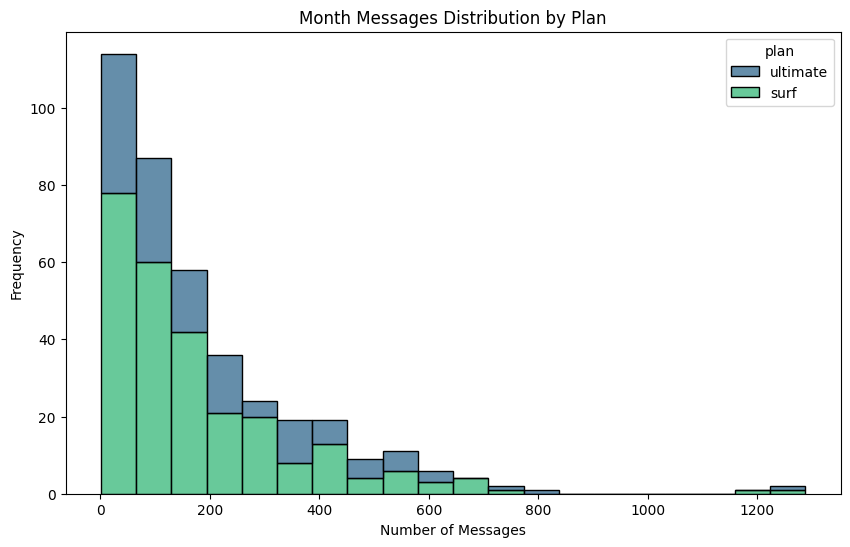

In [ ]:
# < Compare the number of messages that users on each plan usually send each month >

plt.figure(figsize=(10, 6))

sns.histplot(
    data=df_usr_revenue,
    x='messages_month', 
    hue='plan', 
    multiple='stack', 
    palette='viridis', 
    bins=20
)

plt.title('Month Messages Distribution by Plan')
plt.xlabel('Number of Messages')
plt.ylabel('Frequency')
plt.show()

<Figure size 1000x600 with 0 Axes>

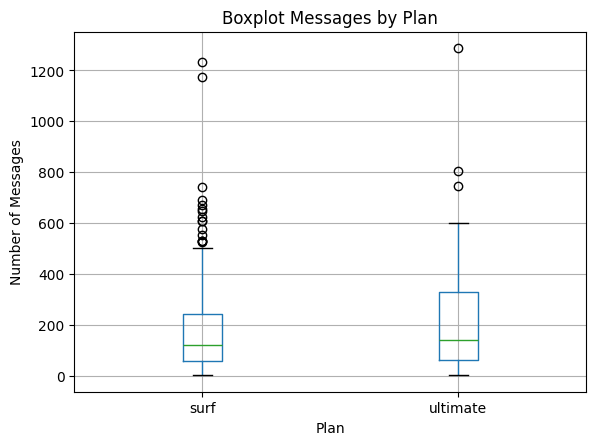

In [578]:
plt.figure(figsize=(10, 6))

df_usr_revenue.boxplot(column='messages_month', by='plan')
plt.title('Boxplot Messages by Plan')
plt.suptitle('')
plt.xlabel('Plan')
plt.ylabel('Number of Messages')
plt.show();

🏷️ **Observation**: 

- Users on the `ultimate` plan tend to send more messages and show greater variability in their behavior compared to users on the `surf` plan.

- **IQR**: Is higher for the `ultimate` plan, indicating greater variability in the number of messages sent.

- **Outliers**: There are more outliers in the `surf` plan, suggesting that some users send a significantly higher number of messages compared to the majority.


#### 3.4.1-Internet user behavior

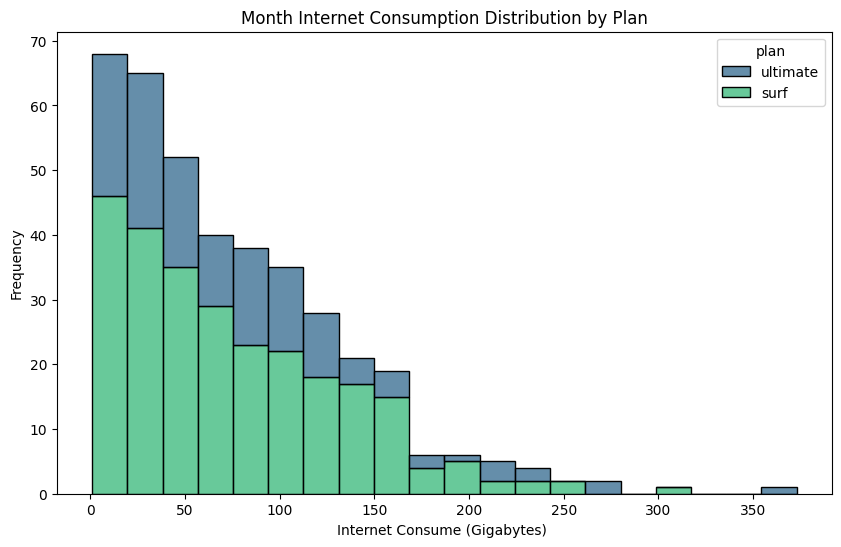

In [ ]:
# < Compares the amount of Internet traffic consumed by users per plan. >

plt.figure(figsize=(10, 6))

sns.histplot(
    data=df_usr_revenue,
    x='internet_month', 
    hue='plan', 
    multiple='stack', 
    palette='viridis', 
    bins=20
)

plt.title('Month Internet Consumption Distribution by Plan')
plt.xlabel('Internet Consume (Gigabytes) ')
plt.ylabel('Frequency')
plt.show()

<Figure size 1000x600 with 0 Axes>

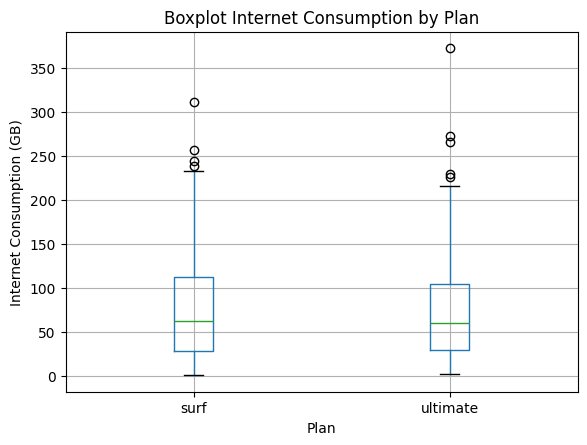

In [580]:
plt.figure(figsize=(10, 6))

df_usr_revenue.boxplot(column='internet_month', by='plan')
plt.title('Boxplot Internet Consumption by Plan')
plt.suptitle('')
plt.xlabel('Plan')
plt.ylabel('Internet Consumption (GB)')
plt.show();

🏷️ **Observation**:
**Consumption by Plan**: Users of the `surf` plan tend to consume more Internet traffic compared to those of the `ultimate` plan.

**Variability**: Both plans show significant variability in consumption, with several users who are **outliers** and consume much more than average.

**User Behavior**: User behavior varies by plan, suggesting that those on the `ultimate` plan have less restrictive data needs and therefore higher usage.

### 3.3-Income

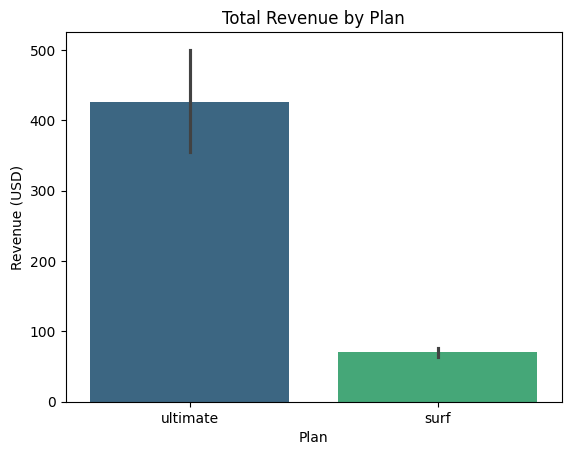

In [581]:
sns.barplot(
    x='plan', 
    y='total_revenue', 
    data=df_usr_revenue,
    hue='plan',
    legend=False,
    palette='viridis'
)
plt.title('Total Revenue by Plan')
plt.xlabel('Plan')
plt.ylabel('Revenue (USD)')
plt.xticks(rotation=0)
plt.show()

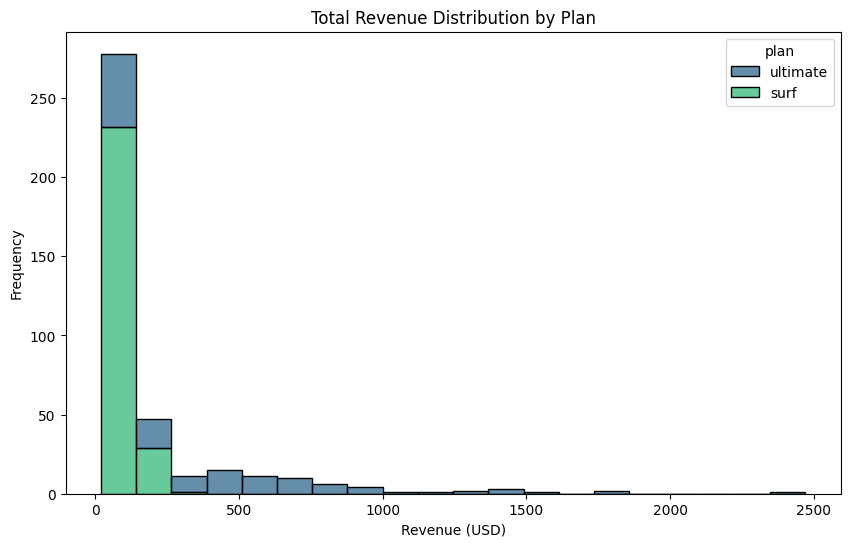

In [582]:
plt.figure(figsize=(10, 6))

sns.histplot(
    data=df_usr_revenue,
    x='total_revenue', 
    hue='plan', 
    multiple='stack', 
    palette='viridis', 
    bins=20
)

plt.title('Total Revenue Distribution by Plan')
plt.xlabel('Revenue (USD)')
plt.ylabel('Frequency')
plt.show()

<Figure size 1000x600 with 0 Axes>

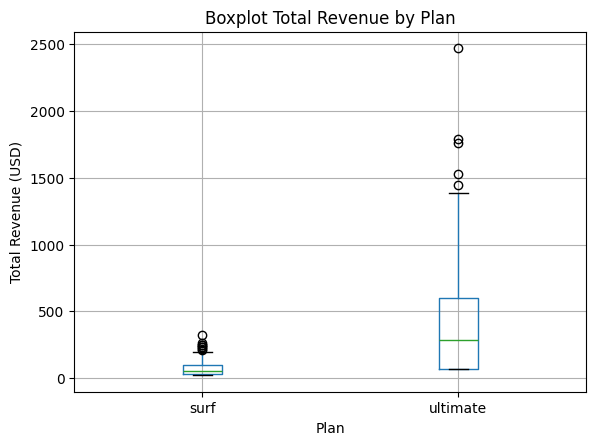

In [583]:
plt.figure(figsize=(10, 6))

df_usr_revenue.boxplot(column='total_revenue', by='plan')
plt.title('Boxplot Total Revenue by Plan')
plt.suptitle('')
plt.xlabel('Plan')
plt.ylabel('Total Revenue (USD)')
plt.show()

🏷️ **Observation**:

- **Median Income**: The `ultimate` plan has a higher median income (**around $700**) compared to the `surf` plan.

- **IQR**: The IQR of the `ultimate` plan is narrower (**100-1400 USD**), indicating more consistent income, while the `surf` plan has a wider IQR **(100-200 USD)**, showing greater variability .

- **Outliers**: The `ultiamte` plan features more outliers, some reaching up to $2,500, suggesting that some customers generate significantly higher income on this plan.

## 4.0-Test the statistical hypotheses

- $H0$ **Null hypothesis**: the means of the two plans are equal
- $H1$ **Alternative hypothesis**: the means of the two plans are different  
- $alpha$ We will use a significance level alpha = 00.5

> [H0] The average income of users of Ultimate and Surf rates differs. 

In [584]:

# < Separate income by plan >
ultimate_revenue = df_usr_revenue[df_usr_revenue['plan'] == 'ultimate']['total_revenue']
surf_revenue = df_usr_revenue[df_usr_revenue['plan'] == 'surf']['total_revenue']

# < Perform the t test >
t_stat, p_value = stats.ttest_ind(ultimate_revenue, surf_revenue)

print(f"t-statistic: {t_stat}, p-value: {p_value}")

# < Interpretation of the result >
if p_value < 0.05:
    print("We reject the null hypothesis. The average incomes are different.")
else:
    print("We cannot reject the null hypothesis. The average income is the same.")

t-statistic: 13.179749629241318, p-value: 4.450732015336573e-33
We reject the null hypothesis. The average incomes are different.


> [H0] The average income of users in the New York-New Jersey state area is different from that of users in other regions.

In [585]:


#  < Separate income by region >
ny_nj_revenue = df_usr_revenue[df_usr_revenue['city'] == 'New York-Newark-Jersey City, NY-NJ-PA MSA']['total_revenue']
other_revenue = df_usr_revenue[df_usr_revenue['city'] != 'New York-Newark-Jersey City, NY-NJ-PA MSA']['total_revenue']

# < Perform two independent samples t test >
t_stat, p_value = stats.ttest_ind(ultimate_revenue, surf_revenue)

# < Show results >
print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")


# < Determine if we reject the null hypothesis >
alpha = 0.05
if p_value < alpha:
    print("We reject the null hypothesis. There is a significant difference in average income between users in the NY-NJ area and users in other regions.")
else:
    print("We cannot reject the null hypothesis. There is no significant difference in average income between users in the NY-NJ area and users in other regions.")

t-statistic: 13.179749629241318
p-value: 4.450732015336573e-33
We reject the null hypothesis. There is a significant difference in average income between users in the NY-NJ area and users in other regions.


## General Conclusion

**Median Income and Variability**:
The `ultimate` plan has a higher (around $700) and more consistent median income (IQR of 100-1400 USD) compared to the `surf` plan (IQR of 100-200 USD), which shows greater variability in the income.

**Outliers (Atypical values)**:
The `ultimate` plan has more outliers, some reaching up to $2,500, suggesting that some customers generate significantly higher income on this plan.

**Average Call Duration**:
Users on the `surf` plan tend to have a slightly longer average call duration compared to those on the `ultimate` plan.

**Internet consumption**:
Users on the `surf` plan tend to consume more Internet traffic compared to those on the `ultimate` plan. Both plans show significant variability in consumption, with several users who are outliers and consume much more than the average.

**Behavior in Messages**:
Users on the `ultimate` plan tend to send more messages and show greater variability in their behavior compared to users on the `surf` plan. The IQR is higher for the ultimate plan, indicating greater variability in the number of messages sent. However, there are more outliers in the 'surf' plan, suggesting that some users send a significantly higher number of messages compared to the majority.

**Formulation of Hypotheses**: 
I chose two independent samples `t test `because we are comparing the average income between two independent groups.

I chose an `alpha` value of **0.05**, which is a commonly accepted level of significance in statistical analyses.
